In [2]:
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer

# 加载数据集
phishing_file_path = '/Users/jiaoyihan/capstone/capstone_project/Processed_CaptstoneProjectData_2024_ngram.csv'
normal_file_path = '/Users/jiaoyihan/capstone/capstone_project/emails.csv'

phishing_data = pd.read_csv(phishing_file_path)
normal_data = pd.read_csv(normal_file_path)

# 填充空值
normal_data['file'] = normal_data['file'].fillna('')
normal_data['message'] = normal_data['message'].fillna('')

# 简单的预处理函数
def simple_preprocess_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\d', ' ', text)
    text = text.lower()
    text = text.replace('________________________________', '')
    words = text.split()
    stop_words = {
        'a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and', 'any', 'are', "aren't", 'as', 'at',
        'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', "can't", 'cannot', 'could',
        "couldn't", 'did', "didn't", 'do', 'does', "doesn't", 'doing', "don't", 'down', 'during', 'each', 'few', 'for',
        'from', 'further', 'had', "hadn't", 'has', "hasn't", 'have', "haven't", 'having', 'he', "he'd", "he'll", "he's",
        'her', 'here', "here's", 'hers', 'herself', 'him', "himself", 'his', 'how', "how's", 'I', "I'd", "I'll", "I'm",
        "I've", 'if', 'in', 'into', 'is', "isn't", 'it', "it's", 'its', 'itself', 'let', "let's", 'me', 'more', 'most',
        "mustn't", 'my', 'myself', 'no', 'nor', 'not', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'ought', 'our',
        'ours', 'ourselves', 'out', 'over', 'own', 'same', "shan't", 'she', "she'd", "she'll", "she's", 'should',
        "shouldn't", 'so', 'some', 'such', 'than', 'that', "that's", 'the', 'their', 'theirs', 'them', 'themselves', 'then',
        'there', "there's", 'these', 'they', "they'd", "they'll", "they're", "they've", 'this', 'those', 'through', 'to',
        'too', 'under', 'until', 'up', 'very', 'was', "wasn't", 'we', "we'd", "we'll", "we're", "we've", 'were',
        "weren't", 'what', "what's", 'when', "when's", 'where', "where's", 'which', 'while', 'who', "who's", 'whom',
        'why', "why's", 'with', "won't", 'would', "wouldn't", 'you', "you'd", "you'll", "you're", "you've", 'your', 'yours',
        'yourself', 'yourselves'
    }
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

# 应用预处理函数到normal_data
normal_data['Cleaned_Text'] = normal_data['file'].apply(simple_preprocess_text) + " " + normal_data['message'].apply(simple_preprocess_text)

# 填充可能的空值
normal_data['Cleaned_Text'] = normal_data['Cleaned_Text'].fillna('')
phishing_data['Cleaned_Text'] = phishing_data['Cleaned_Text'].fillna('')

# 初始化 N-gram Vectorizer
ngram_vectorizer = CountVectorizer(ngram_range=(1, 3), max_features=2000)  # 1到3-gram，限制最多2000个特征

# 合并数据集进行特征提取
combined_texts = pd.concat([phishing_data['Cleaned_Text'], normal_data['Cleaned_Text']], ignore_index=True)

# 提取N-gram特征
combined_ngram_matrix = ngram_vectorizer.fit_transform(combined_texts)

# 将 N-gram 矩阵转换为 DataFrame 以便于可视化
combined_ngram_df = pd.DataFrame(combined_ngram_matrix.toarray(), columns=ngram_vectorizer.get_feature_names_out())

# 将标签添加回数据框
combined_ngram_df['Label'] = [1] * len(phishing_data) + [0] * len(normal_data)

# 保存 N-gram 特征到 CSV 文件，不带索引
output_file_path = '/Users/jiaoyihan/capstone/capstone_project/combined_emails_ngram_with_labels.csv'
combined_ngram_df.to_csv(output_file_path, index=False)

print(f"N-gram Features with labels are saved to a file: {output_file_path}")


KeyError: 'Cleaned_Text'

data column: Index(['able', 'access', 'account', 'account will', 'accounts', 'action',
       'action required', 'active', 'activity', 'address',
       ...
       'version content', 'version content type', 'vince', 'vince kaminski',
       'wed', 'wednesday', 'white', 'william', 'williams', 'york'],
      dtype='object', length=863)
 accuracy: 0.9999903842455479
classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    103447
           1       1.00      1.00      1.00       549

    accuracy                           1.00    103996
   macro avg       1.00      1.00      1.00    103996
weighted avg       1.00      1.00      1.00    103996



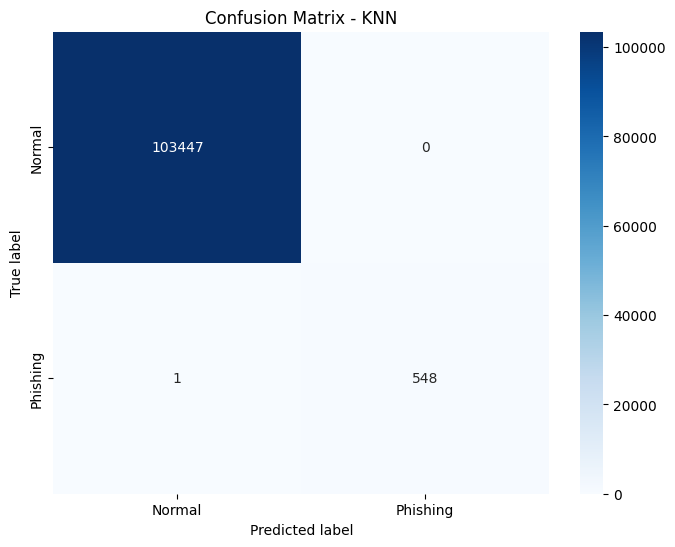

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 加载数据集
file_path = '/Users/jiaoyihan/capstone/capstone_project/Combined_emails_ngram.csv'
data = pd.read_csv(file_path)

# 打印列名以检查标签列的名称
print("data column:", data.columns)

# 填充缺失值（这里使用0进行填充，也可以使用其他策略）
data = data.fillna(0)

# 确认标签列名，假设标签列名为 'label'
label_column = 'label'

# 检查标签列是否存在
if label_column not in data.columns:
    raise KeyError(f"dataset are not inlude'{label_column}'label column。")

# 分割特征和标签
X = data.drop(label_column, axis=1)
y = data[label_column]

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 初始化KNN模型
model = KNeighborsClassifier(n_neighbors=5)

# 在训练集上训练模型
model.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = model.predict(X_test)

# 计算准确率
accuracy = accuracy_score(y_test, y_pred)
print(f" accuracy: {accuracy}")

# 打印分类报告
print("classification report:")
print(classification_report(y_test, y_pred))

# 生成混淆矩阵
conf_matrix = confusion_matrix(y_test, y_pred)

# 绘制混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Phishing'], yticklabels=['Normal', 'Phishing'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix - KNN')
plt.show()
